In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import sys
sys.path.append("../utils")
sys.path.append("../data/")
from dataconfig import *
from utils import *
import numpy as np 

{'SPARSE_FEATURES': ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26'], 'DENSE_FEATURES': ['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13'], 'label': ['label']}


In [16]:
np.set_printoptions(precision=4, suppress=True)

In [3]:
spase_feature_names = DATA_CONFIG['SPARSE_FEATURES']
dense_feature_names = DATA_CONFIG['DENSE_FEATURES']
label_feature_names = DATA_CONFIG['label']


In [4]:

dataset = DataUtil(spase_feature_names, dense_feature_names, label_feature_names).read_tfrecord("../data/tf_data/train_criteo_5w_rows.tfrecord", 512)
eval_data = DataUtil(spase_feature_names, dense_feature_names, label_feature_names).read_tfrecord("../data/tf_data/test_criteo_1w_rows.tfrecord", 512)
valid_data = DataUtil(spase_feature_names, dense_feature_names, label_feature_names).read_tfrecord("../data/tf_data/valid_criteo_1w_rows.tfrecord", 512)
# 定义 inputs
inputs = { name:keras.Input(shape=(1,), name=name, dtype=tf.float32) for name in dense_feature_names }
inputs.update({
    name:keras.Input(shape=(1,), name=name, dtype=tf.string) for name in spase_feature_names
})

In [5]:

numeric_inputs = { name:value for name, value in inputs.items() if value.dtype == tf.float32 }
x = layers.Concatenate()(list(numeric_inputs.values()))
# 用log 处理？
# norm = layers.Normalization()
# norm.adapt(np.array(titanic[numeric_inputs.keys()]))
# x = norm(x)
preprocessed_inputs = [x]
num_bins = 10000
embedding_dim = 8
sparse_inputs = { name:value for name, value in inputs.items() if value.dtype == tf.string }
for name, input in sparse_inputs.items():
    #是否能跑通？
    lookup = keras.layers.Hashing(num_bins=num_bins)
    embedding_layer = layers.Embedding(input_dim=num_bins, output_dim=8)
    x = lookup(input)
    x = embedding_layer(x)
    x = tf.squeeze(x, axis = 1)
    preprocessed_inputs.append(x)

In [21]:
sparse_inputs

{'C1': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'C1')>,
 'C2': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'C2')>,
 'C3': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'C3')>,
 'C4': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'C4')>,
 'C5': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'C5')>,
 'C6': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'C6')>,
 'C7': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'C7')>,
 'C8': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'C8')>,
 'C9': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'C9')>,
 'C10': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'C10')>,
 'C11': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'C11')>,
 'C12': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'C12')>,
 'C13': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'C13')>,
 'C1

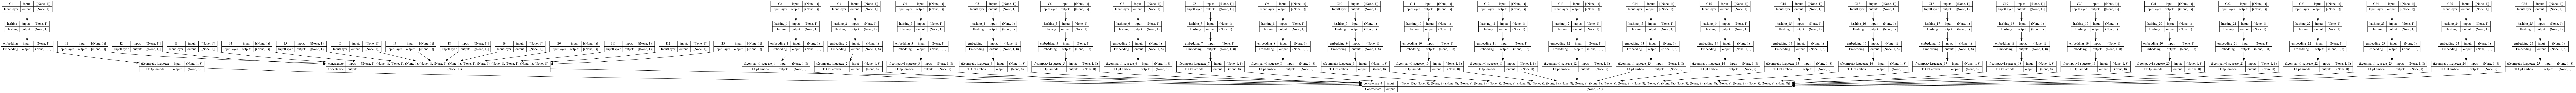

In [23]:
results = layers.Concatenate()(preprocessed_inputs)
process_model = keras.Model(inputs, results)
tf.keras.utils.plot_model(model = process_model, dpi = 75,
                         show_shapes=True )

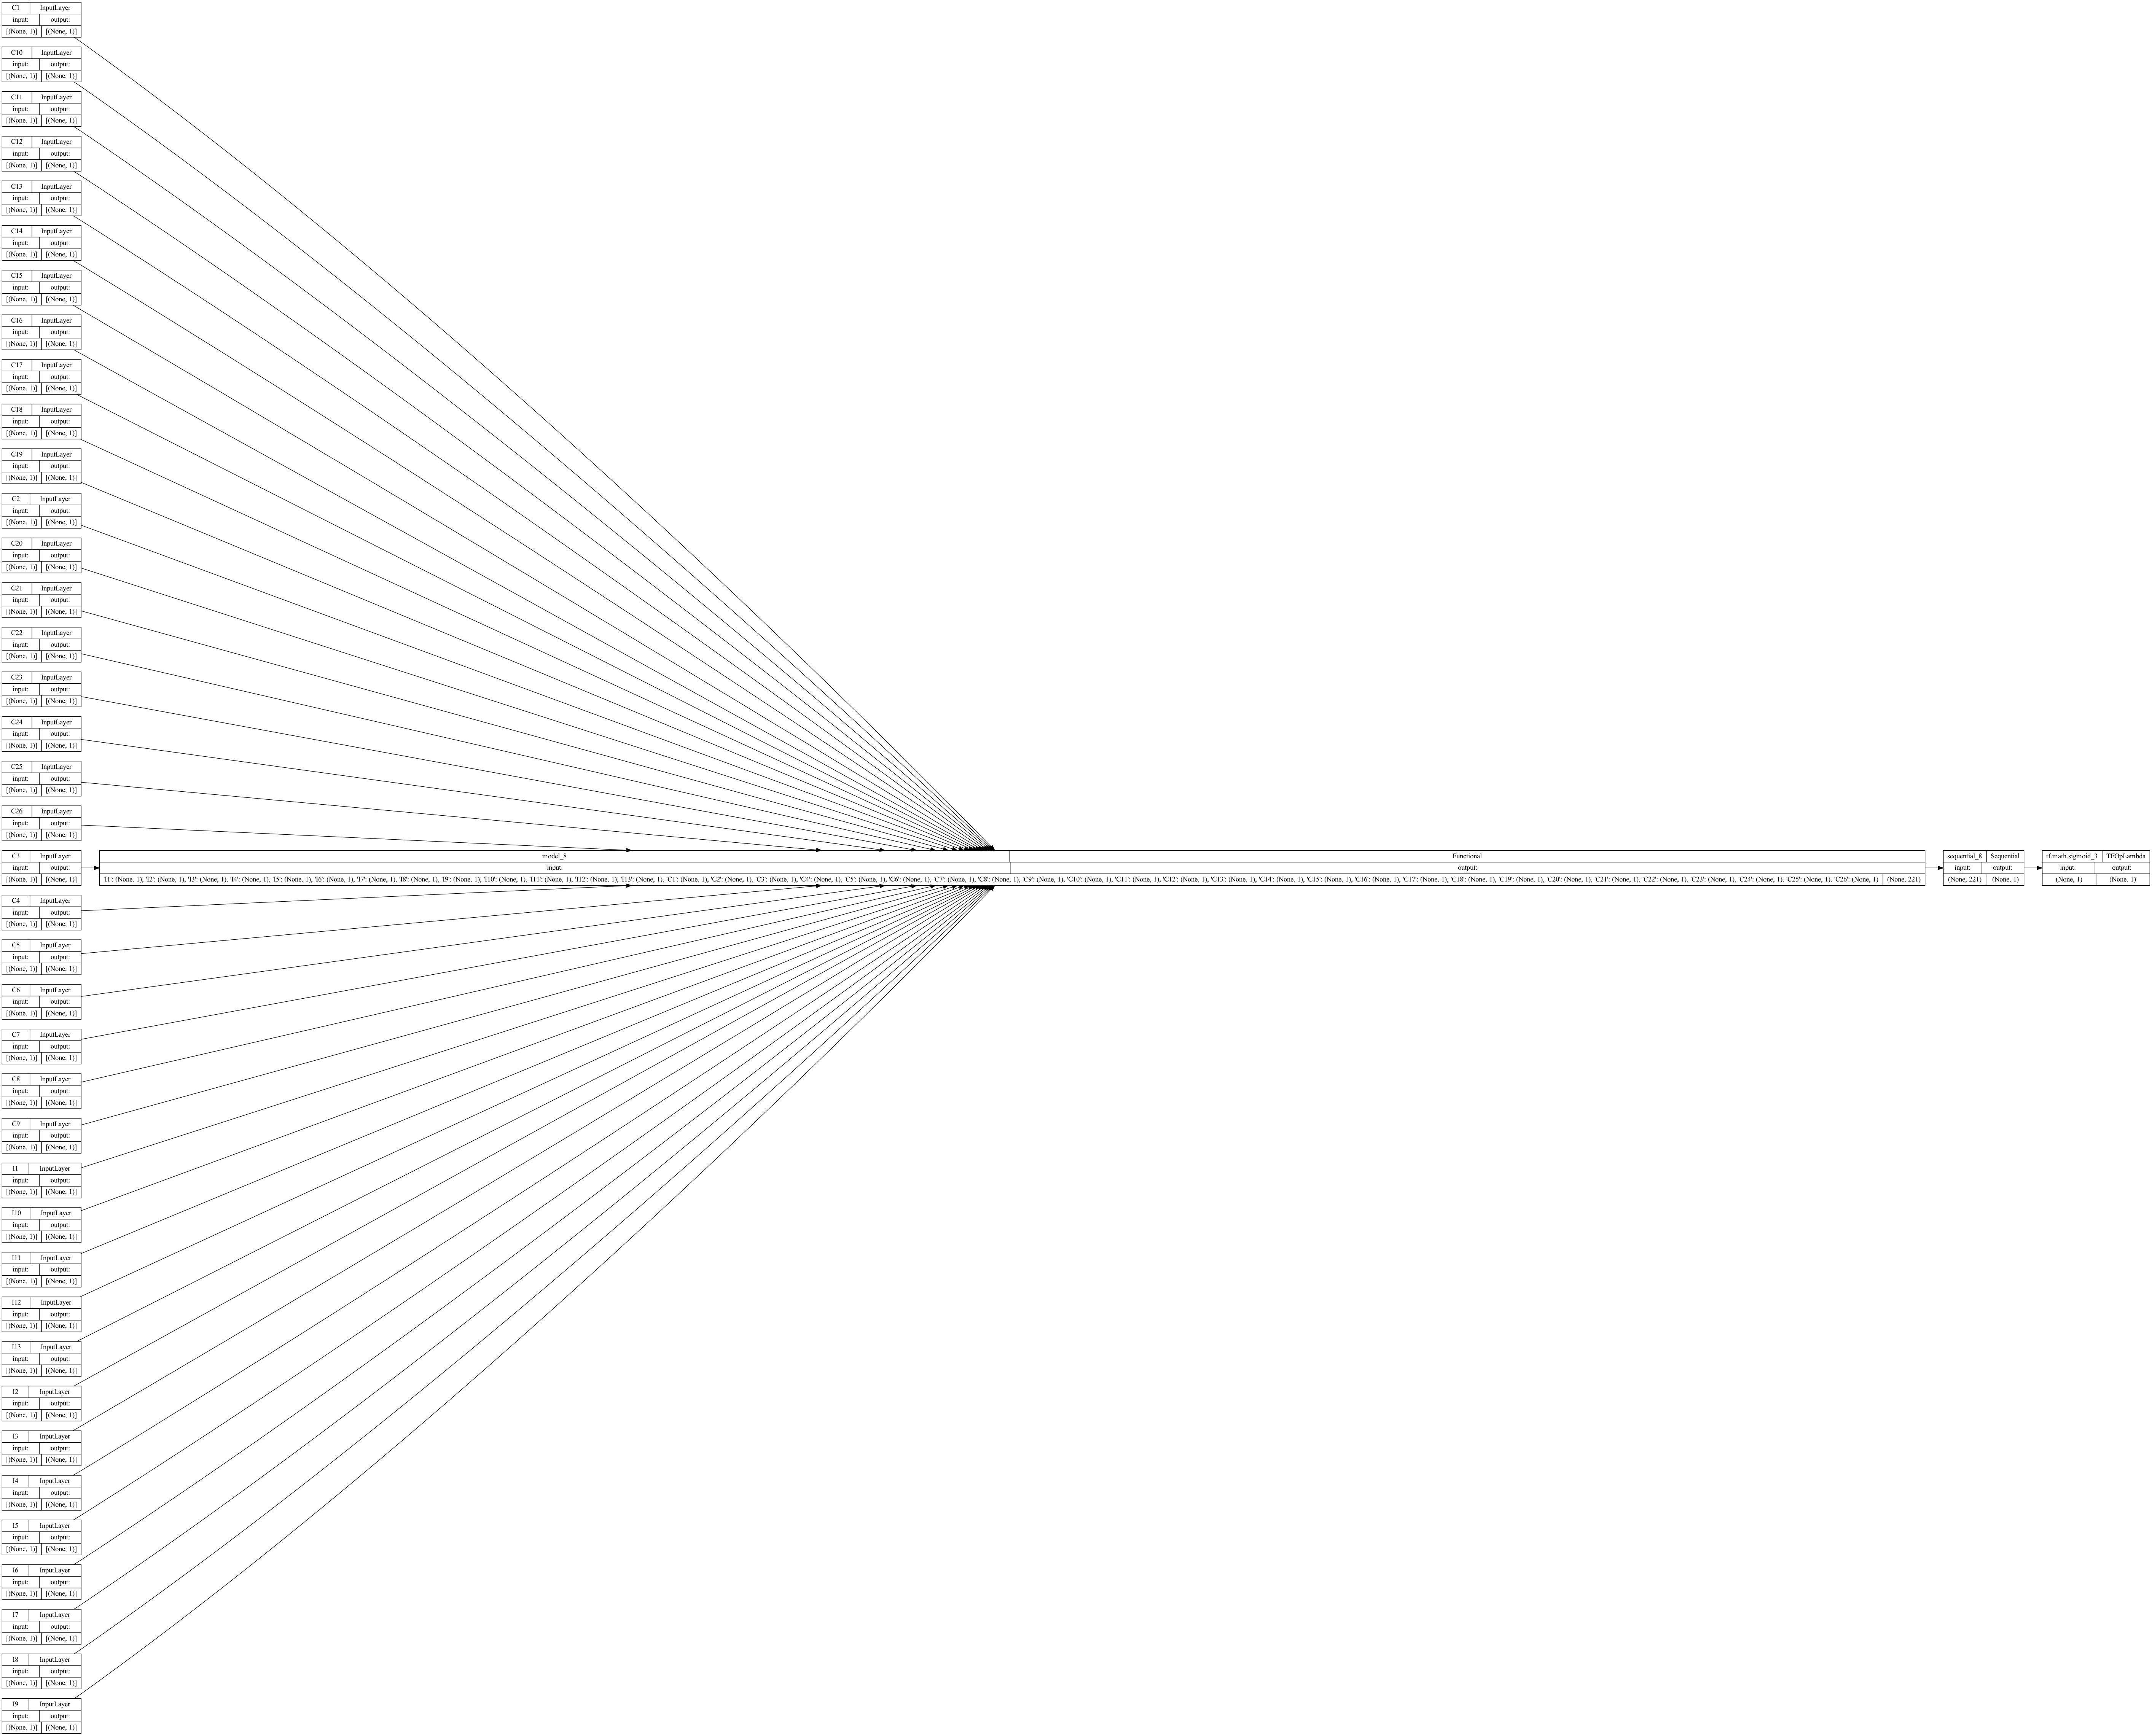

In [30]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import keras

class Custom_Model(Model):
    def __init__(self, preprocess_model, units, inputs_shape):
        super().__init__()
        self.preprocess_model = preprocess_model
        self.dnn = keras.Sequential()
        self.inputs_example = inputs_shape
        for unit in units:
            self.dnn.add(
                layers.Dense(unit, activation='relu')
            )
        self.dnn.add(layers.Dense(1))

    def call(self, inputs):
        x = self.preprocess_model(inputs)
        x = self.dnn(x)
        return tf.sigmoid(x)

    def train_step(self, inputs, label):
        with tf.GradientTape() as tape:
            predict = self(inputs)
            losses = self.loss(label, predict)

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(losses, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        results = {m.name: m.result() for m in self.metrics}
        return results
        
    def model(self):
        return Model(inputs=[self.inputs_example], outputs=self.call(self.inputs_example))


model = Custom_Model(process_model, [256, 128, 64], inputs)



# 使用 plot_model 显示模型架构
keras.utils.plot_model( model.model(), rankdir='LR', show_shapes=True, expand_nested = True)


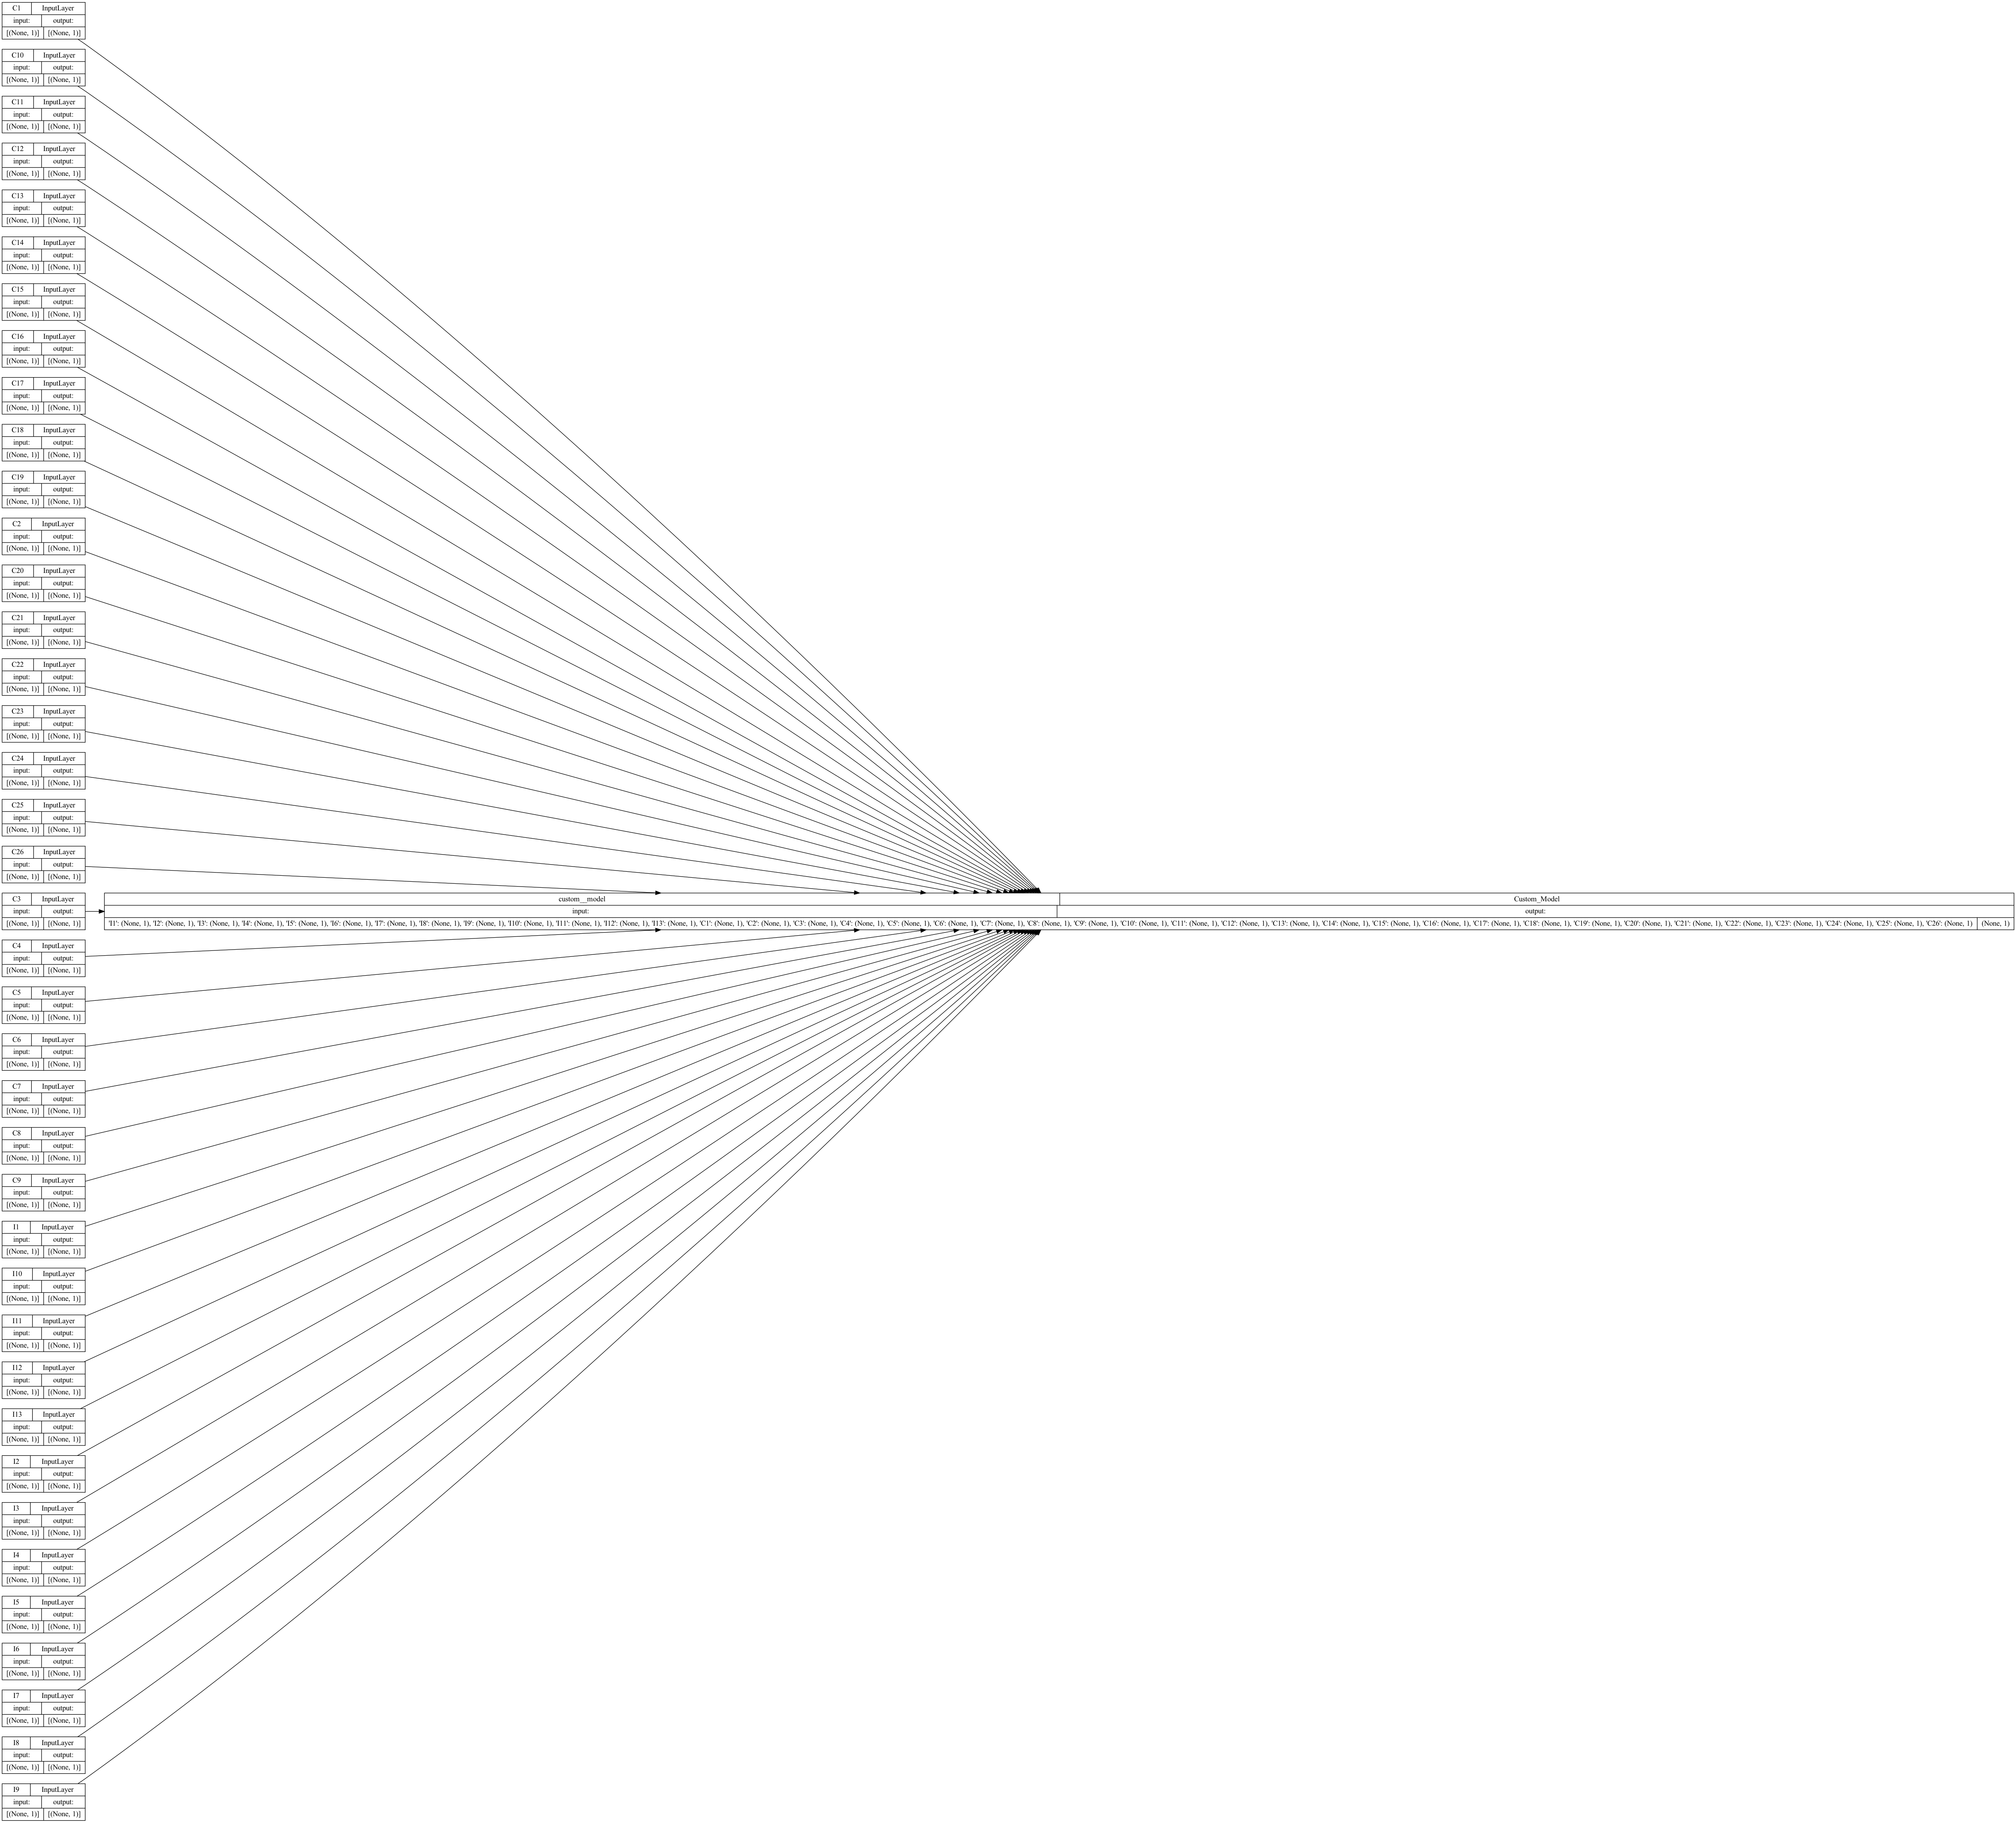

In [11]:
import tensorflow as tf

class Dummy(tf.keras.Model):
    def __init__(self, name="dummy"):
        super(Dummy, self).__init__()
        self._name = name

        self.dense1 = tf.keras.layers.Dense(4, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(5, activation=tf.nn.softmax)

    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        return self.dense2(x)

model = Dummy()
model.build(input_shape=(None,5))

In [7]:
def get_xy_fd():
    # Notice: History behavior sequence feature name must start with "hist_".
    behavior_feature_list = ["item_id", "cate_id"]
    uid = np.array([0, 1, 2])
    ugender = np.array([0, 1, 0])
    iid = np.array([1, 2, 3])  # 0 is mask value
    cate_id = np.array([1, 2, 2])  # 0 is mask value
    pay_score = np.array([0.1, 0.2, 0.3])

    hist_iid = np.array([[1, 2, 3, 0], [3, 2, 1, 0], [1, 2, 0, 0]])
    hist_cate_id = np.array([[1, 2, 2, 0], [2, 2, 1, 0], [1, 2, 0, 0]])
    seq_length = np.array([3, 3, 2])  # the actual length of the behavior sequence

    feature_dict = {'user': uid, 'gender': ugender, 'item_id': iid, 'cate_id': cate_id,
                    'hist_item_id': hist_iid, 'hist_cate_id': hist_cate_id,
                    'pay_score': pay_score, 'seq_length': seq_length}
    x = feature_dict
    y = np.array([1, 0, 1])
    return x, y, behavior_feature_list

In [8]:
x, y, behavior_list = get_xy_fd()

In [15]:
inputs = { name : keras.Input(name = name, shape = (1,), dtype =  tf.float32 ) for name, v in x.items() if name not in behavior_list}

In [17]:
inputs.update(
    {name: keras.Input(name = name, shape = (len(v), ), dtype = tf.int64) for name, v in x.items() if name in behavior_list }
)

In [9]:
from tensorflow.keras import Model
class Var_Model(Model):
    def __init__(self, inputs, behavior_list, log2_features):

        numeric_features = [] 
        
        for name, input in inputs:
            if name in log2_features:
                x = tf.experimental.numpy.log2(input)
            elif name in log10_features:
                x = tf.experimental.numpy.log2(input)
            numeric_features.append(x)

        

{'user': array([0, 1, 2]),
 'gender': array([0, 1, 0]),
 'item_id': array([1, 2, 3]),
 'cate_id': array([1, 2, 2]),
 'hist_item_id': array([[1, 2, 3, 0],
        [3, 2, 1, 0],
        [1, 2, 0, 0]]),
 'hist_cate_id': array([[1, 2, 2, 0],
        [2, 2, 1, 0],
        [1, 2, 0, 0]]),
 'pay_score': array([0.1, 0.2, 0.3]),
 'seq_length': array([3, 3, 2])}

In [13]:
import tensorflow as tf

In [4]:
import tensorflow as tf
x1 = tf.constant([1.0,2,3])

In [ ]:
# input 能不能传入 tf运算中， 
# 变量 tf.embedding 能不能有用， + 自定义 长度 

In [6]:
x = tf.constant([0, 0.5, 1, 5])
tf.experimental.numpy.log2(
    x1 + 1
)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1.   , 1.585, 2.   ], dtype=float32)>

In [ ]:
x = tf.constant([0, 0.5, 1, 5])